# Undersampling

# Table Of Content
- [Imports](#imports)
- [Load Data](#load-data)
- [Data First Insights](#data-first-insights)
- [Length vs Labels](#length-vs-labels)
- [Word Clouds for each cluster](#word-clouds-for-each-cluster)
- [Top 3 words for each cluster](#top-3-words-for-each-cluster)
- [Simple Cleaning](#simple-cleaning)
- [Exploring errors by score](#exploring-errors-by-score)
- [MANN WHITNEY U TEST](#mann-whitney-u-test)
- [Vocabulary Coverage with Glove Wikipedia](#vocabulary-coverage-with-glove-wikipedia)
- [Vocabulary Coverage with Glove Twitter](#vocabulary-coverage-with-glove-twitter)
- [LEVENSTHEIN Distances Ratio Matrix](#levensthein-distances-ratio-matrix)
- [Vocabulary Coverage for TRANSFORMERS](#vocabulary-coverage-for-transformers)
- [Vocabulary Final Analysis](#vocabulary-final-analysis)
- [Data Reduction & Visualization](#data-reduction--visualization)
  - [LSA - Latent Semantic Analysis](#lsa---latent-semantic-analysis)
  - [GloVe + UMAP](#glove--umap)
  - [BGE + UMAP](#bge--umap)
  - [BGE + PCA](#bge--pca)
  - [FastText + UMAP](#fasttext--umap)
- [Topic Extraction with KMEANS and LDA (Latent Dirichlet Allocation)](#topic-extraction-with-kmeans-and-lda-latent-dirichlet-allocation)
  - [Word Clouds for the 7 clusters](#word-clouds-for-the-7-clusters)
  - [Top 3 words of the 7 clusters](#top-3-words-of-the-7-clusters)
  - [LDA](#lda)
- [Conclusion](#conclusion)

## Imports

In [1]:
import pandas as pd
import numpy as np
from skimpy import skim

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler


from typing import List, Optional

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

## Problem Statement

<img src="./../../rsrc/idea.png" alt="Explanation Image" width="50" height="50">

<div style="border: 2px solid red; padding: 10px;">

* We consider the parent population with *N* essays, and *r* distinct grades *C1, C2, ..., C6*

* Let *Ni* be the number of essays with grade *Ci* and *pi = Ni/N* the proportion of essays with grade *Ci* in the parent population.

* We aim to constitute a balanced and representative sample of the parent population.

</div>

<img src="./../../rsrc/exp.png" alt="Explanation Image" width="50" height="50">

<div style="border: 2px solid red; padding: 10px;">

### Statistical Elements

* To achieve the correct levels of proportion in a balanced and representative sample, the sample size must be sufficient for the observed proportions in the sample to be close to the actual proportions in the parent population.

* The larger the sample size, the more likely the observed proportions are to be close to the actual proportions.

* There is a formula to calculate the necessary sample size to achieve a given precision:

$$
n = \frac{Z^2 \cdot p_i \cdot (1 - p_i)}{E^2} 
$$

where:

  - $n$ is the sample size
  - $Z$ is the desired confidence coefficient
  - $p_i$ is the proportion of the parent population with grade \( i \)
  - $E$ is the desired margin of error

</div>

In [3]:
df = pd.read_csv('../../train_cleaned.csv')

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.2, stratify=df_train['labels'], random_state=42)

In [7]:
df = pd.concat([df_train, df_val])

In [8]:
df.head()

,text,labels,length,stemmed_text,simple_cleaned_text,corrected_text,n_errors,ratio_err
13042,In the story making mona lisa smile the author...,3,423,stori make mona lisa smile author talk interst...,the story making mona lisa smile the author ta...,the story making mona lisa smile the author ta...,16,0.037825
13674,The last ship to try to land on Venus was thre...,2,342,ship try land venu decad ago astronot scientis...,the last ship try land venus was three decades...,the last ship try land venus was three decades...,13,0.038012
2349,electrol college is not just a college it is a...,1,715,electrol colleg colleg process elector colleg ...,electrol college not just college process the ...,electrola college not just college process the...,20,0.027972
5257,"Many countries are pushing towards less cars, ...",5,608,countri push car ultimatelycr better world lim...,many countries are pushing towards less cars u...,many countries are pushing towards less cars m...,3,0.004934
1064,Do voters some times get confused about the el...,2,277,voter time confus elect vote wrong candid sing...,voters some times get confused about the elect...,voters some times get confused about the lecte...,8,0.028881


In [9]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 13845  │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 8      │ │ int64       │ 3     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name     ┃ NA  ┃ NA %   ┃ mean    ┃ sd      ┃ p0    ┃ p25      ┃ p50     ┃ p75    ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ labels          │   0 │      0 │     2.9 │       1 │     1 │        2 │       3 │      4 │     6 │  ▂▆▇▅▁  │  │
│ │ length          │   0 │      0 │     410 │     170 │   150 │      280 │     380 │    500 │  1700 │   ▇▅▁   │  │
│ │ n_errors        │   0 │      0 │     5.3 │     4.8 │     0 │        2 │       4 │      7 │    68 │   ▇▁    │  │
│ │ ratio_err       │   0 │      0 │   0.014 │   0.013 │     0 │   0.0053 │   0.011 │  0.019 │  0.15 │   ▇▁    │  │
│ └─────────────────┴─────┴────────┴─────────┴─────────┴───────┴──────────┴─────────┴────────┴───────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                          ┃ NA    ┃ NA %      ┃ words per row            ┃ total words          ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ text                                 │     0 │         0 │                      380 │              5314822 │  │
│ │ stemmed_text                         │     0 │         0 │                      160 │              2149305 │  │
│ │ simple_cleaned_text                  │     0 │         0 │                      290 │              4019571 │  │
│ │ corrected_text                       │     0 │         0 │                      290 │              4021328 │  │
│ └──────────────────────────────────────┴───────┴───────────┴──────────────────────────┴──────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [6]:
N = df.shape[0]
print(f'There are  {N} points')
r = df['labels'].nunique()
print(f'There are {r} classes :')
Ni = {i: df[df['labels']==i].shape[0] for i in range(1,r+1)}
pi = {i+1: Ni[i+1]/N for i in range(r)}
for i in range(r):
    print(f'\tThe class {i+1} contains {Ni[i+1]} points :  {pi[i+1]*100:.2f}% of data points')

There are  17307 points
There are 6 classes :
	The class 1 contains 1252 points :  7.23% of data points
	The class 2 contains 4723 points :  27.29% of data points
	The class 3 contains 6280 points :  36.29% of data points
	The class 4 contains 3926 points :  22.68% of data points
	The class 5 contains 970 points :  5.60% of data points
	The class 6 contains 156 points :  0.90% of data points


In [7]:
Ni

{1: 1252, 2: 4723, 3: 6280, 4: 3926, 5: 970, 6: 156}

In [12]:
pi

{1: 0.07230046948356808,
 2: 0.27287829541350667,
 3: 0.36287468400144457,
 4: 0.2268689057421452,
 5: 0.056049115204044785,
 6: 0.00902853015529072}

In [13]:
fig = px.histogram(df, x='labels', title='Distribution of labels', nbins=20, width=800, height=400, text_auto=True)
fig.show()

### Exploration

<img src="./../../rsrc/exp.png" alt="Explanation Image" width="50" height="50">

<div style="border: 2px solid red; padding: 10px;">

* First, we want to achieve a precision of 0.05 (i.e., a margin of error of 5%) with a confidence level of 95%.

* We want to determine the corresponding sample sizes for each grade n1, n2, ..., n6.

</div>

In [14]:
def get_n(z: float, p: float, e: float) -> int:
    """
    Method to compute the sample size for a given confidence level, proportion and margin error for a population
    :param z: z-score corresponding to the confidence level (e.g. 1.96 for 95%)
    :param p: proportion of the population of the class of interest
    :param e: margin error
    :return: sample size
    """

    return int((z**2 * p * (1 - p)) / (e**2))

In [15]:
confidence_level = 0.95
margin_error = 0.05
z = 1.96

In [16]:
sample_size = {k: get_n(z=z, p=v, e=margin_error) for k, v in pi.items()}

In [17]:
sample_size

{1: 103, 2: 304, 3: 355, 4: 269, 5: 81, 6: 13}


<img src="./../../rsrc/exp.png" alt="Explanation Image" width="50" height="50">

<div style="border: 2px solid red; padding: 10px;">
                 - We can determine the minimum sample size by taking the maximum of each subsample to achieve a 5% precision for each of the 6 proportions.
</div>

In [8]:
min_sample_size = max(sample_size.values())
print(f"Sample size for the population: {min_sample_size}")

Sample size for the population: 355


### Sensitivity Analysis on the Margin of Error

In [19]:
margin_errors = [0.001, 0.01, 0.05, 0.1]

sample_sizes = {e: {k: get_n(z=z, p=v, e=e) for k, v in pi.items()} for e in margin_errors}

In [20]:
sample_sizes

{0.001: {1: 257668, 2: 762233, 3: 888165, 4: 673814, 5: 203249, 6: 34370},
 0.01: {1: 2576, 2: 7622, 3: 8881, 4: 6738, 5: 2032, 6: 343},
 0.05: {1: 103, 2: 304, 3: 355, 4: 269, 5: 81, 6: 13},
 0.1: {1: 25, 2: 76, 3: 88, 4: 67, 5: 20, 6: 3}}

In [21]:
fig = px.bar(x=margin_errors, y=[max(v.values()) for v in sample_sizes.values()], labels={"x": "margin error", "y": "sample size"}, text_auto=True)
fig.add_scatter(x=margin_errors, y=[max(v.values()) for v in sample_sizes.values()], mode="lines")
fig.show()

<img src="./../../rsrc/idea.png" alt="Explanation Image" width="50" height="50">

<div style="border: 2px solid red; padding: 10px;">

* We can see that from 8,881 rows, we will have a data sample that represents our base sample.

* We ignore the margin of error of 0.001 because 888,148 data points are too large. We will subsequently determine the optimal number of data points to take.

* To formally establish an undersampling threshold, a relevant approach is to use **Hoeffding's Inequality** or **Chernoff's Inequality**.

* These methods allow quantification of the deviation of a sum of random variables (the labels) from the expected mean with a well-defined probability.

</div>

## Hoeffding's Inequality

Hoeffding's Inequality can be used to estimate the minimum number of samples $n_i$ in each class $i$ to ensure that the observed frequency $p'_i$ of class $i$ in the sample remains close to the actual frequency $p_i$ with a given confidence level.

$$
P\left( \left| \frac{1}{n} \sum_{i=1}^{n} X_i - \mathbb{E}[X] \right| \geq \epsilon \right) \leq 2 \exp\left( -2n\epsilon^2 \right) 
$$

where:
- $n$ is the number of samples,
- $X_i$ are the random variables,
- $\mathbb{E}[X]$ is the expected mean,
- $\epsilon$ is the deviation from the mean.

Objective of this inequality:

         - Estimation of the deviation of the sample mean from the theoretical mean

         - Determination of the required number of data points based on precision and confidence level


In [22]:
def get_hoeffding(alpha: float, epsilon: float) -> float:
    """
    Calculate the Hoeffding's sample size for a given confidence level (alpha) and error tolerance (epsilon).

    Args:
        alpha (float): Confidence level (between 0 and 1).
        epsilon (float): Error tolerance (positive value).

    Returns:
        float: Hoeffding's sample size.

    Raises:
        ValueError: If alpha is not between 0 and 1, or epsilon is not a positive value.
    """
    if not 0 < alpha < 1:
        raise ValueError("alpha must be between 0 and 1")
    if epsilon <= 0:
        raise ValueError("epsilon must be a positive value")

    return np.log(2 / alpha) / (2.0 * (epsilon ** 2))


In [24]:
errors: List[float] = np.linspace(start=0.01, stop=0.1, num=10)
tol_err: List[float] = np.linspace(start=0.01, stop=0.1, num=10)
list_ni = np.zeros((10, 10))
for i, alpha in enumerate(tol_err):
    for j, epsilon in enumerate(errors):
        ni = get_hoeffding(alpha, epsilon)
        list_ni[i,j] = ni

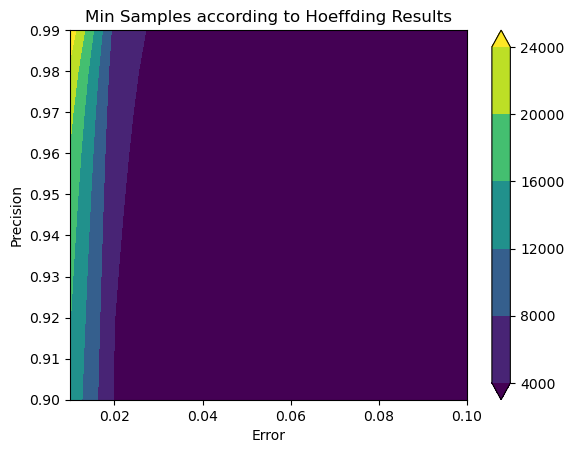

In [25]:
x, y  = errors.flatten(), tol_err.flatten()
y = 1 - y

z = list_ni
   
cs = plt.contourf(x, y, z,
                  extend ='both', 
                  alpha = 1) 
  
plt.colorbar(cs) 
  
plt.title('Min Samples according to Hoeffding Results') 
plt.xlabel('Error')
plt.ylabel('Precision')
plt.show() 

In [26]:
fig = px.imshow(list_ni, x=errors, y=1- tol_err, labels={"x": "error", "y": "precision"}, text_auto=True, title="Hoeffding's sample size")
fig.show(width=150, height=150)

In [27]:
thresholds = [18500, 19600, 21000, 23100, 26500]

In [28]:
print(f"Number needed per class: {int(np.ceil(26500/6))} (for a precision of 0.99 and an error of 0.01)")

Number needed per class: 4417 (for a precision of 0.99 and an error of 0.01)


## Discussion 1

<img src="./../../rsrc/insights.png" alt="Explanation Image" width="250" height="250">

<div style="border: 2px solid red; padding: 10px;">

* According to the statistical analysis, the number of samples to be taken is between 8,881 and 888,148 to respect the distribution of each class \( i \).

* According to Hoeffding's Inequality, the optimal number of samples to take can be  18500, 19600, 21000, 23100 or 26500 according to the error margin we want

* Since all the values are between 8,881 and 888,148, all of them respect the distribution conditions.

* **To have balanced classes, we divide selected optimal value by the number of classes (6) and we get our undersampling threshold.**

</div>

In [29]:
colors = ['red', 'green', 'yellow', 'blue', 'black']

In [30]:
fig = px.histogram(df, x='labels', title='Distribution of labels Vs Thrushold', nbins=20, width=800, height=400, text_auto=True)
for i,t in enumerate(thresholds):
    fig.add_shape(type="line", x0=0, y0=t/6, x1=7, y1=t/6, line=dict(color=colors[i], width=1))
fig.show()

In [31]:
thresholds = [np.ceil(t/6) for t in thresholds]

In [32]:
deltas = {}
for i in range(1, 7):
    size = df[df['labels']== i].shape[0]
    delta = [t-size for t in thresholds]
    deltas[i] = delta
    

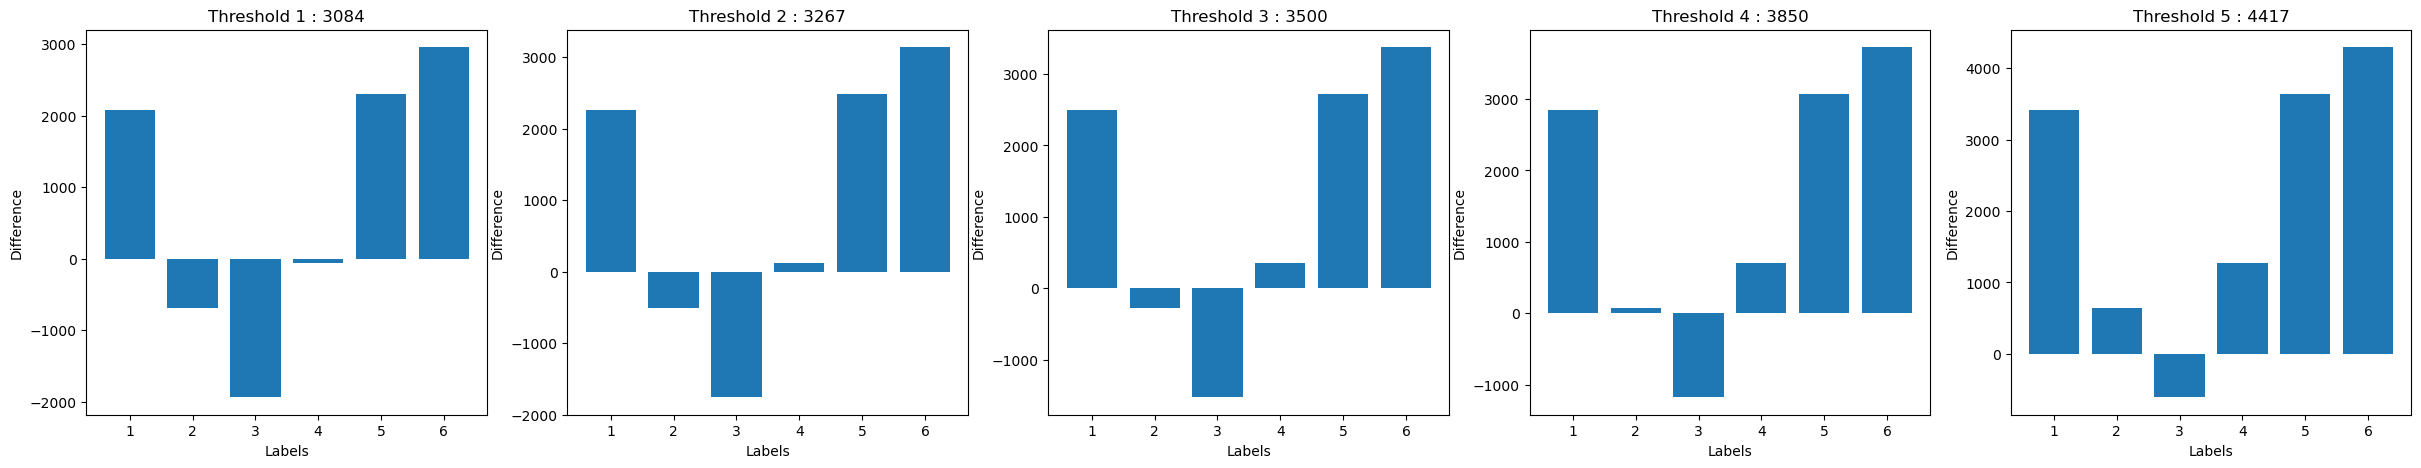

In [33]:
fig, ax = plt.subplots(1,5, figsize=(30, 5))

for i in range(5):
    ax[i].bar(deltas.keys(), [deltas[k][i] for k in deltas.keys()])
    ax[i].set_title(f"Threshold {i+1} : {int(thresholds[i])}")
    ax[i].set_xlabel('Labels')
    ax[i].set_ylabel('Difference')
    
plt.show()    

In [34]:
fig = px.histogram(df, x='labels', title='Distribution of labels Vs Thrushold', nbins=20, width=800, height=400, text_auto=True)

fig.add_shape(type="line", x0=0, y0=thresholds[0], x1=7, y1=thresholds[0], line=dict(color='red', width=1))
fig.show()

## Discussion 2

<img src="./../../rsrc/insights.png" alt="Explanation Image" width="250" height="250">

<div style="border: 2px solid red; padding: 10px;">

* We have tried to determine the adequate thresholds and map the impact on the data to ascertain how many labels are going to be undersampled versus how many of them are going to be oversampled.

* We have concluded that the adequate threshold is 3,084, as it splits the classes in half: 3 classes to oversample and 3 classes to undersample.

* Next, we are going to see the undersampling technique. The oversampling technique is demonstrated in the `oversampling.ipynb`.

</div>

In [35]:
classes_undersampling = [2,3,4]
classes_oversampling = [i for i in range(1, 7) if i not in classes_undersampling]

print(f"Classes to undersample: {classes_undersampling}")
print(f"Classes to oversample: {classes_oversampling}")

Classes to undersample: [2, 3, 4]
Classes to oversample: [1, 5, 6]


# Undersampling Technique

In [38]:
def plot_violins(df: pd.DataFrame, 
                 x: str, 
                 y: str,
                 output_path: Optional[str] = None) -> None:
    """
    Plot violin plots

    Args:
        df {pd.DataFrame} -- the dataframe
        x {str} -- the x-axis
        y {str} -- the y-axis
        output_path {Optional[str]} -- the output path
    """
    
    plt.figure(figsize=(10, 6))
    sns.violinplot(x=x, y=y, data=df)
    plt.title(f'{y} vs {x}')
    if output_path:
        plt.savefig(output_path)
    plt.show()

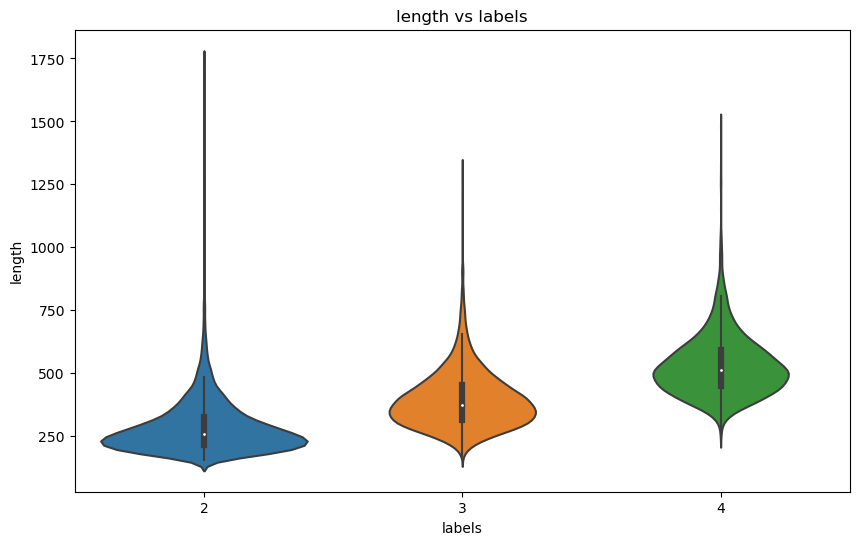

In [39]:
plot_violins(df[df['labels'].isin(classes_undersampling)], 'labels', 'length')

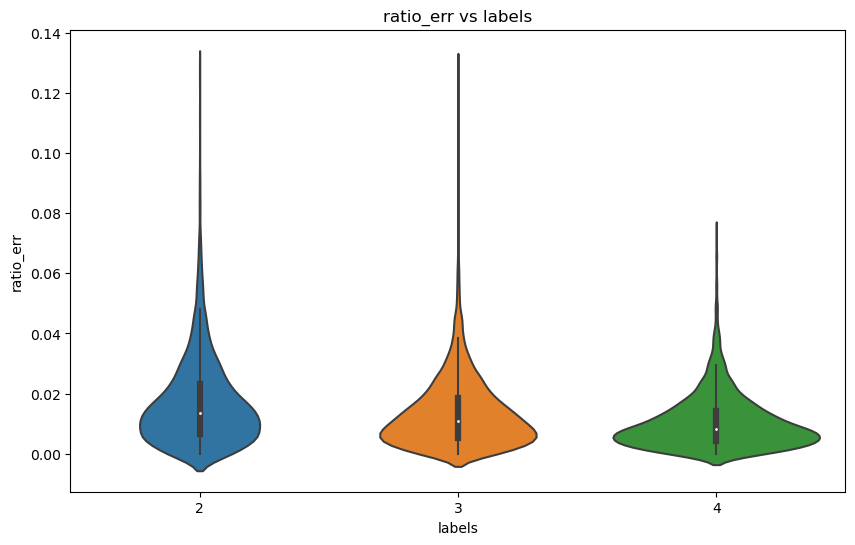

In [40]:
plot_violins(df[df['labels'].isin(classes_undersampling)], 'labels', 'ratio_err')

**Dans notre sous-echantillonnage, on veut garder les mêmes caractéristiques pour les deux classes**

<img src="./../../rsrc/exp.png" alt="Explanation Image" width="50" height="50">

<div style="border: 2px solid red; padding: 10px;">

- We want to keep the exact same feature characteristics for the classes.

</div>

In [42]:
data_class_2_3_4 = df[df['labels'].isin(classes_undersampling)]

In [43]:
dict_under = {i: int(thresholds[0]) for i in classes_undersampling}

In [44]:
dict_under

{2: 3084, 3: 3084, 4: 3084}

In [45]:
under_sampler = RandomUnderSampler(sampling_strategy=dict_under, random_state=42)

In [46]:
X_undersampled, y_undersampled = under_sampler.fit_resample(data_class_2_3_4.drop('labels', axis=1), data_class_2_3_4['labels'])

In [47]:
X_undersampled['labels'] = y_undersampled

In [48]:
X_undersampled

,text,length,stemmed_text,simple_cleaned_text,corrected_text,n_errors,ratio_err,labels
834,Some people think that the face on mars was cr...,174,peopl think face mar creat alien essai tell fa...,some people think that the face mars was creat...,some people think that the face mars was creat...,0,0.000000,2
3118,The article is called The challenge of Explori...,316,articl call challeng explor venu author make e...,the article called the challenge exploring ven...,the article called the challenge exploring ven...,2,0.006329,2
9452,The electoral college is a process that has be...,276,elector colleg process presid elect question r...,the electoral college process that has been us...,the electoral college process that has been us...,3,0.010870,2
4089,Google is trying to make things easy by creati...,276,googl try thing easi creat driveless car new c...,google trying make things easy creating drivel...,google trying make things easy creating driver...,7,0.025362,2
1575,"Dear State Senator,\r\n\r\nI am writing to you...",262,dear state senat write tell chang popular vote...,dear state senator writing you tell you that s...,dear state senator writing you tell you that s...,1,0.003817,2
...,...,...,...,...,...,...,...,...
10298,People all over the world like to try new thin...,660,peopl world like try new thing everydai face n...,people all over the world like try new things ...,people all over the world like try new things ...,1,0.001515,4
6215,Autonomous cares have been dreamt of for sever...,341,autonom care dreamt gener theyv gone multipl c...,autonomous cares have been dreamt for several ...,autonomous cares have been dreamt for several ...,7,0.020528,4
6116,As time goes on technology improves day by day...,498,time goe technolog improv dai dai live world t...,time goes technology improves day day live wor...,time goes technology improves day day live wor...,9,0.018072,4
1033,The author does not support his idea well beca...,464,author support idea littl evid claim claim ven...,the author does not support his idea well beca...,the author does not support his idea well beca...,2,0.004310,4


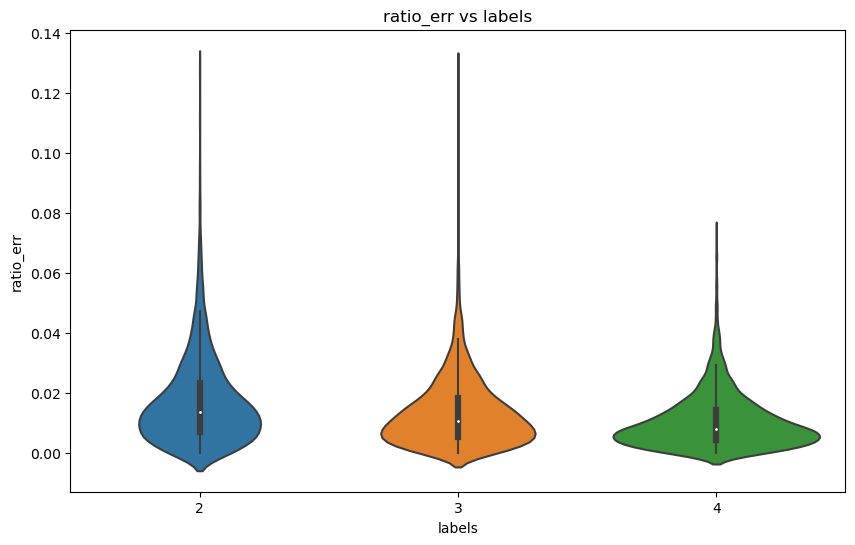

In [49]:
plot_violins(X_undersampled, 'labels', 'ratio_err')

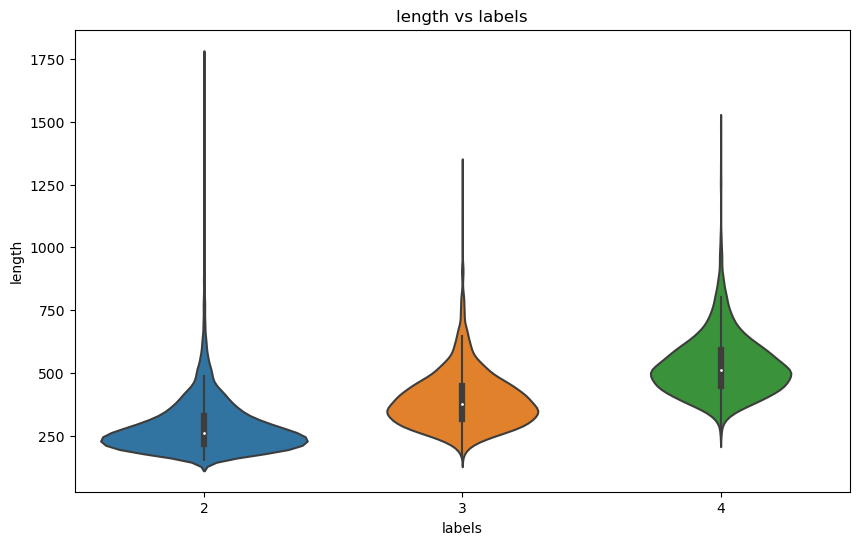

In [50]:
plot_violins(X_undersampled, 'labels', 'length')

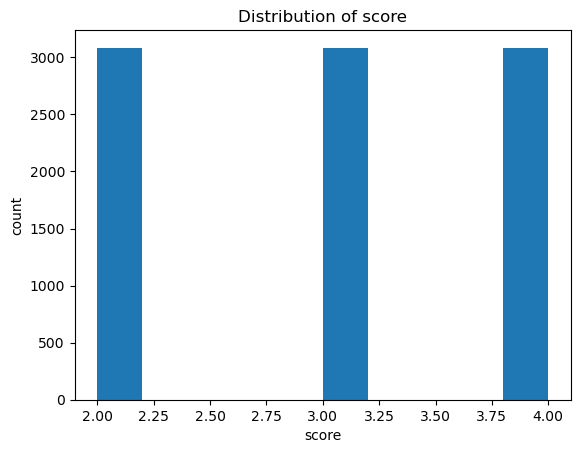

In [51]:
plt.hist(X_undersampled['labels'])
plt.xlabel('score')
plt.ylabel('count')
plt.title('Distribution of score')
plt.show()

In [52]:
final_df = pd.concat([df[df['labels'].isin(classes_oversampling)], X_undersampled])

In [53]:
final_df.head()

,text,labels,length,stemmed_text,simple_cleaned_text,corrected_text,n_errors,ratio_err
2349,electrol college is not just a college it is a...,1,715,electrol colleg colleg process elector colleg ...,electrol college not just college process the ...,electrola college not just college process the...,20,0.027972
5257,"Many countries are pushing towards less cars, ...",5,608,countri push car ultimatelycr better world lim...,many countries are pushing towards less cars u...,many countries are pushing towards less cars m...,3,0.004934
2992,keeping the\r\n\r\nElectoral College would be ...,1,425,keep elector colleg best choic select elector ...,keeping the electoral college would the best c...,keeping the electoral college would the best c...,9,0.021176
6224,"Authors that present a well-developed, convinc...",5,667,author present develop convinc argument larg i...,authors that present well developed convincing...,authors that present well developed convincing...,10,0.014993
10327,"When I was reading this article, it brought to...",1,273,read articl brought attent venu worthi pursuit...,when was reading this article brought attentio...,when was reading this article brought attentio...,1,0.003663


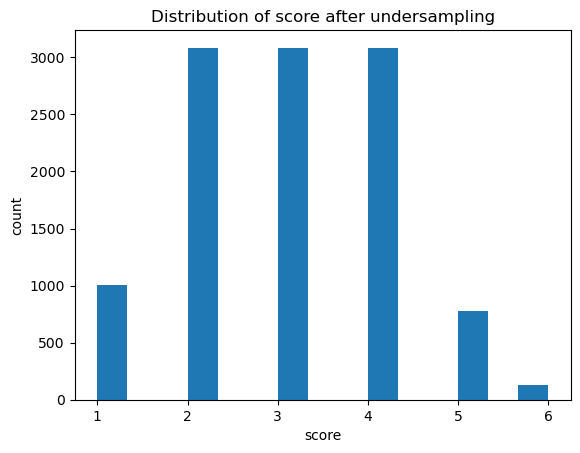

In [54]:
plt.hist(final_df['labels'], bins=15)
plt.xlabel('score')
plt.ylabel('count')

plt.title('Distribution of score after undersampling')
plt.show()

In [156]:
final_df = final_df[['corrected_text', 'length', 'ratio_err', 'labels']]

In [157]:
df_train, df_val = train_test_split(final_df, test_size=0.2, stratify=final_df['labels'], random_state=42)

In [163]:
df_train.to_csv('./../../data/train_under.csv', index=False)
df_val.to_csv('./../../data/val_under.csv', index=False)

## Conclusion

<img src="./../../rsrc/insights.png" alt="Explanation Image" width="200" height="200">

<div style="border: 2px solid green; padding: 10px;">

* A deep statistical study was made

</div>